In the overview notebook we have explored bitcoin price index behavior alongside with other economic indexes, review our overivew notebook here:
https://github.com/liwen611/project-bitcoin/blob/master/bitcoin_overview.ipynb

In this notebook, we focused on the economic indexes that give us high correlation on bitcoin's monthly prices and try out linear regression and random forest methods and see which of this index carry more weight in giving us the insight of the bitcoin price trend.

In this notebook, we use historical data with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. We use the weighted price index as it provides more granity and information with the change in exchange volumns as well. Data is downloadable through:

https://www.kaggle.com/mczielinski/bitcoin-historical-data

The original data is retrieved from multiple APIs. 

In [1]:
import pandas as pd
import numpy as np
import datapungi_fed as dpf
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

# Download Data 

In [49]:
#bit = dpf('CBBTCUSD')
bit = pd.read_csv('data/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv')
bit['Timestamp'] = pd.to_datetime(bit['Timestamp'], unit='s')
bit = bit.set_index('Timestamp')
bit_monthly = bit.resample('MS').mean()

In [50]:
# note that we are using the monthly average for the modeling
bit_monthly.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-01,4.465000,4.482500,4.465000,4.482500,23.829470,106.330084,4.471603
2012-01-01,6.345389,6.348982,6.341218,6.346148,4.031777,25.168238,6.345955
2012-02-01,5.230208,5.231646,5.227036,5.228510,8.313993,42.239422,5.228443
2012-03-01,4.985481,4.986695,4.982580,4.983828,15.197791,76.509751,4.984397
2012-04-01,4.995171,4.996447,4.993763,4.995079,21.683913,108.218094,4.995091


In [44]:
# the data covers 2012 to current day and daily unjusted prices
bit.index.min(), bit.index.max()

(Timestamp('2011-12-31 07:52:00'), Timestamp('2020-04-22 00:00:00'))

In [55]:
# monthly unemployment rate, Personal Consumption Expenditures, Effective Federal Funds Rate, Consumer Price Index
unrate = dpf('UNRATE')
pce = dpf('PCE')
fedfund = dpf('FEDFUNDS')
cpi = dpf('CUSR0000SEHE')
# these data are monthly updated

In [51]:
# sp500
sp = dpf('SP500').resample('MS').mean()

In [77]:
unrate.columns = ['unemployment']
pce.columns = ['pce']
fedfund.columns = ['fedfund']
cpi.columns = ['cpi']
sp.columns = ['sp']

In [78]:
data = bit_monthly.join(unrate, how = 'left')
data = data.join(pce, how = 'left')
data = data.join(fedfund, how = 'left')
data = data.join(cpi, how = 'left')
data = data.join(sp, how = 'left')

In [82]:
data.head()

,Weighted_Price,unemployment,pce,fedfund,cpi,sp
Date,,,,,,
2011-12-01,4.471603,8.5,10772.2,0.07,341.472,1243.322857
2012-01-01,6.345955,8.3,10862.1,0.08,338.522,1300.577500
2012-02-01,5.228443,8.3,10953.5,0.10,339.818,1352.487500
2012-03-01,4.984397,8.2,10951.8,0.13,339.337,1389.240000
2012-04-01,4.995091,8.2,10979.7,0.14,344.224,1386.429000


In [80]:
data.drop(columns = ['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)'], inplace = True)

In [81]:
data.index.name = 'Date'

# Correlation with other Economic Indexes

In this session we visualize and explore the monthly change in bitcoin price and other economic indexes. Here we will use the perchange change therefore all the indexes can be on the scale.

In [76]:
data.fillna(method = 'ffill', inplace = True)

In [83]:
data['bit_pct'] = data['Weighted_Price'].pct_change()
data['unrate_pct'] = data['unemployment'].pct_change()
data['pce_pct'] = data['pce'].pct_change()
data['fed_pct'] = data['fedfund'].pct_change()
data['pi_pct'] = data['cpi'].pct_change()
data['sp_pct'] = data['sp'].pct_change()

In [85]:
data.drop(columns = ['Weighted_Price', 'unemployment', 'pce', 'fedfund', 'cpi', 'sp'], inplace = True)

/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


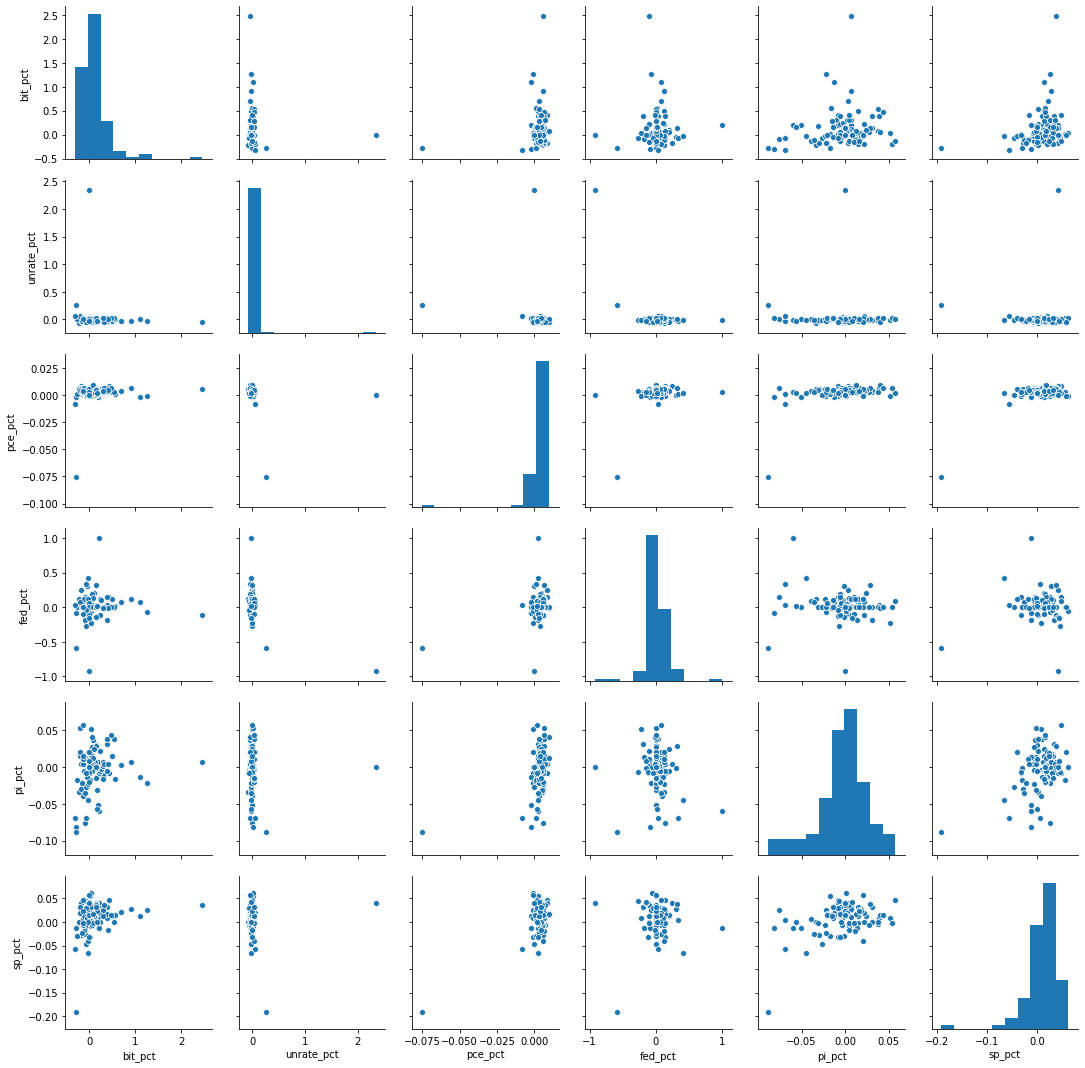

In [87]:
sns.pairplot(data = data)

In [98]:
corr = data.corr()
corr

,bit_pct,unrate_pct,pce_pct,fed_pct,pi_pct,sp_pct
bit_pct,1.000000,-0.056769,0.129515,0.004900,0.151491,0.264654
unrate_pct,-0.056769,1.000000,-0.140900,-0.556740,-0.022466,0.023727
pce_pct,0.129515,-0.140900,1.000000,0.359518,0.401107,0.650425
fed_pct,0.004900,-0.556740,0.359518,1.000000,-0.115361,0.052481
pi_pct,0.151491,-0.022466,0.401107,-0.115361,1.000000,0.410607
sp_pct,0.264654,0.023727,0.650425,0.052481,0.410607,1.000000


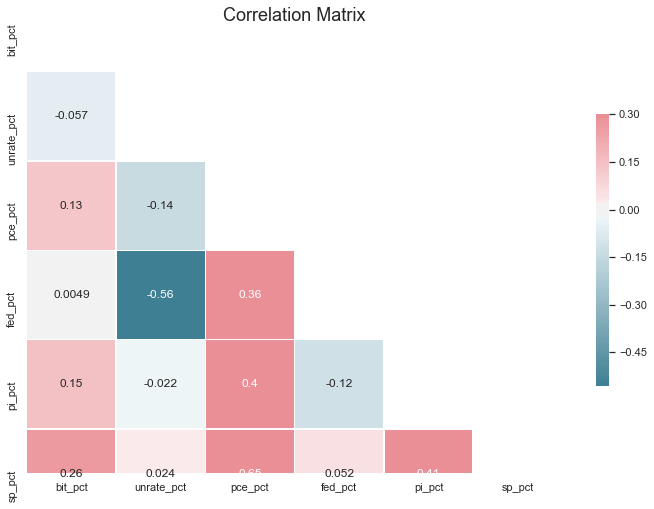

In [102]:
sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlation Matrix', fontsize=18)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

* We can see that the our data mostly have a fairly skewed distribution. 
* This is a dataset with multicolinearity problem. For example, fedfund is also closely relate to unemployment. Which makes senese with economic policy as the backdrop.

Therefore, we expect problem using linear modeling methods.


Even after reducing the data to percentage change, bitcoin price still display weak to moderate correlation with PCE (personal Expendure Index), Fedfunds, and (PI) Peronal income index and unemployment.

# Linear Regression

In [103]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import scipy.stats as stats
from sklearn import metrics

In [104]:
data.head()

,bit_pct,unrate_pct,pce_pct,fed_pct,pi_pct,sp_pct
Date,,,,,,
2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,0.419168,-0.023529,0.008346,0.142857,-0.008639,0.046050
2012-02-01,-0.176098,0.000000,0.008415,0.250000,0.003828,0.039913
2012-03-01,-0.046677,-0.012048,-0.000155,0.300000,-0.001415,0.027174
2012-04-01,0.002145,0.000000,0.002548,0.076923,0.014402,-0.002023


In [105]:
mod = smf.ols(formula = 'bit_pct ~ unrate_pct + pce_pct + fed_pct + pi_pct + sp_pct', data = data)
results = mod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                bit_pct   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.693
Date:                Mon, 11 May 2020   Prob (F-statistic):              0.144
Time:                        14:41:49   Log-Likelihood:                -34.153
No. Observations:                 100   AIC:                             80.31
Df Residuals:                      94   BIC:                             95.94
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1014      0.038      2.642      0.0

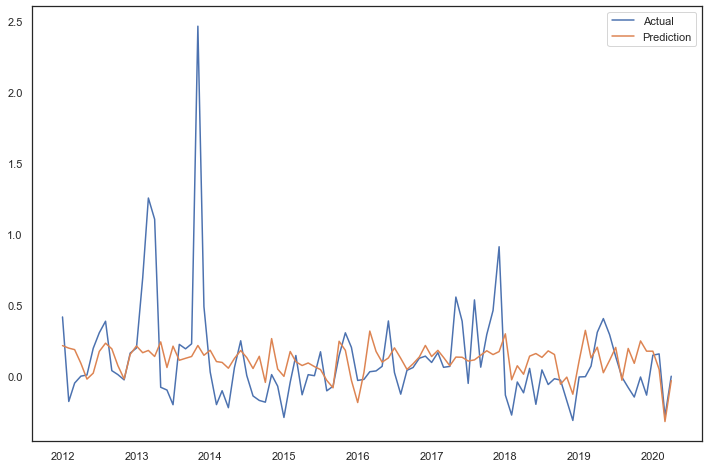

In [176]:
plt.figure(figsize = (12, 8))
sns.lineplot(data = data['bit_pct'], label = 'Actual')
sns.lineplot(data = results.fittedvalues, label = 'Prediction')

As we are expecting, linear model is not fairing too well.

# Linear Model Diagnosis
As mentioned before, we expect linear modeling techniques to be problematic with our current dataset. In this section, we run the diagnostics to check for linear assumption, residuls patterns, influential data points to confirm our expectations.

In [106]:
# evaluate the model
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals, fitted)
top5 = abs(residuals).sort_values(ascending = False)[:5]

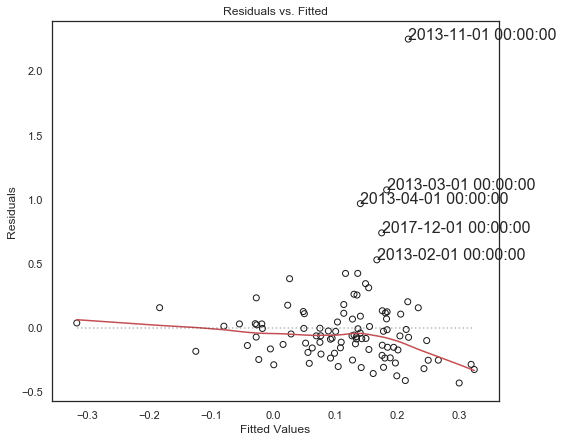

In [107]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top5.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

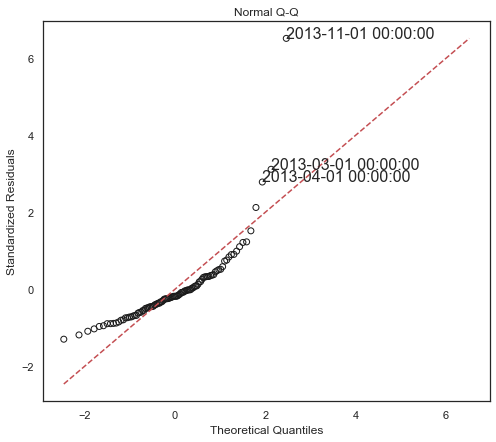

In [108]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()

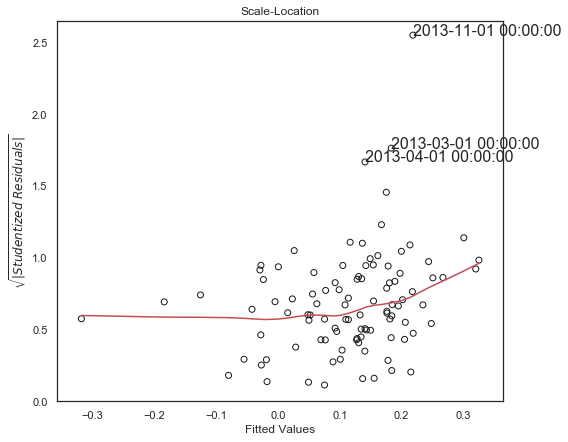

In [109]:
student_residuals = results.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = results.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
plt.show()

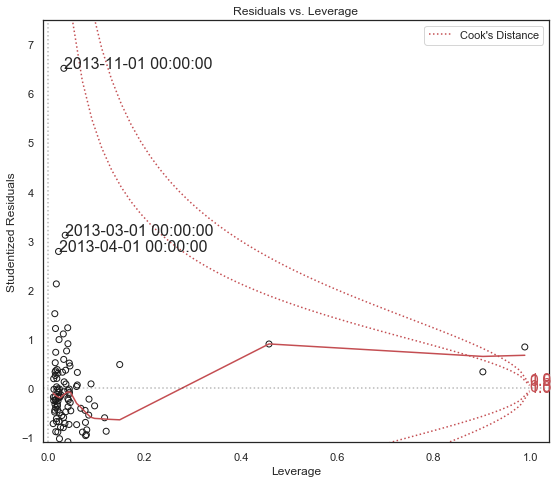

In [110]:
student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
student_residuals.index = results.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = results.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)
plt.tight_layout()
for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(results.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.show()

# Random Forest 
In this session, we try out the random forest method. Since tree-based models do not assume underlying distribution assumptions, and the ensembled technique helps untangle the correlated variables, we expect to come up with a better prediction.

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [113]:
data.head()

,bit_pct,unrate_pct,pce_pct,fed_pct,pi_pct,sp_pct
Date,,,,,,
2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,0.419168,-0.023529,0.008346,0.142857,-0.008639,0.046050
2012-02-01,-0.176098,0.000000,0.008415,0.250000,0.003828,0.039913
2012-03-01,-0.046677,-0.012048,-0.000155,0.300000,-0.001415,0.027174
2012-04-01,0.002145,0.000000,0.002548,0.076923,0.014402,-0.002023


In [180]:
data.dropna(inplace = True)
data.shape

(100, 6)

In [ ]:
X = data.iloc[:, 1:]
y= data.iloc[:, 0]

In [126]:
# use 10 trees for starter and just default setting to train the first ensembled tree
regressor = RandomForestRegressor(n_estimators = 10, random_state = 42)

In [127]:
regressor.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [132]:
feature_imp = pd.Series(regressor.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

pce_pct       0.335858
unrate_pct    0.187188
fed_pct       0.183971
sp_pct        0.165282
pi_pct        0.127701
dtype: float64

No handles with labels found to put in legend.


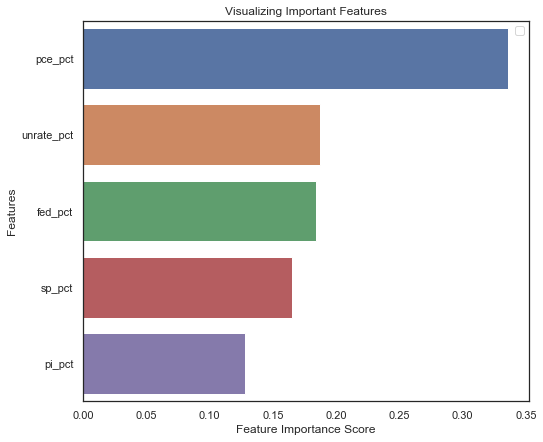

In [133]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()

In [141]:
# evaluate prediction accuracy
predictions = regressor.predict(X)
y = y.to_frame()
y['prediction'] = predictions

The rmse is : 0.0199481216781161
The mae is : 0.0881176175081398


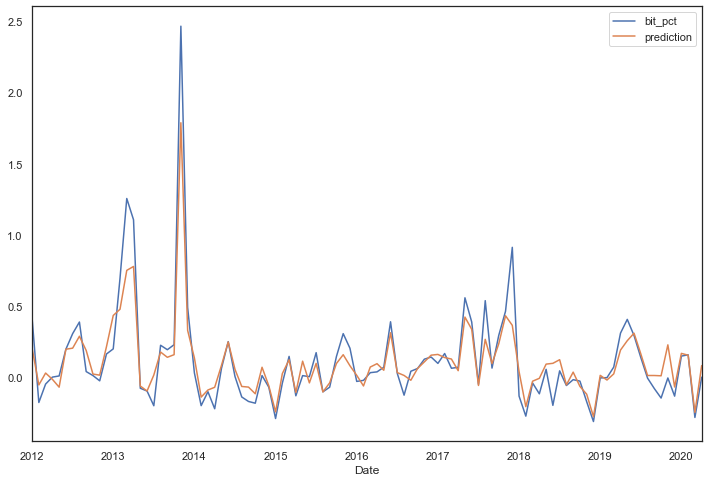

In [178]:
y.plot(figsize = (12,8))
print("The rmse is :", metrics.mean_squared_error(y['bit_pct'], predictions))
print("The mae is :", metrics.mean_absolute_error(y['bit_pct'], predictions))

The prediction of the random forest model better than the linear model in the way that it is able to predict the upward and downward movement,  but it also failed to capture the magnitudes of the peaks of price changes.

# Model Tuning
Although the random forest model was not able to offer us with very accuarte prediction at this point, but we can see its potential. In order to harvest its predicting power, we need to do some model hyperparameter tunning. 

Since we don't actually have that many data points, we won't go through the traditional train, validation, test set split but just do the train, test splits in order to give the model more input. Note that this is a time series data and our goal is to forcast, we will use a train test split based on time. We would use the first 80% data points for training and hold out the later 20 data points for testing our model.

## Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [184]:
X_train, X_test = data.iloc[:80, 1:],  data.iloc[80:, 1:]
y_train, y_test = data.iloc[:80, 0], data.iloc[80:, 0]

In [185]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 5), (20, 5), (80,), (20,))

 Here are the couple of parameters we consider for tunning:
  * n_estimators = number of trees in the foreset
  
  * max_features = max number of features considered for splitting a node
  
  * max_depth = max number of levels in each decision tree
  
  * min_samples_split = min number of data points placed in a node before the node is split
    
  * min_samples_leaf = min number of data points allowed in a leaf node
    
  * bootstrap = method for sampling data points (with or without replacement)

In [207]:
# check the parameter for the last model
regressor.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)>

In [209]:
# use grid search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 3, stop = 15, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 21, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [3, 9, 15], 'max_features': ['auto', 'sqrt'], 'max_depth': [3, 12, 21, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [228]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 50, scoring='neg_mean_absolute_error', 
                              verbose=1, random_state=42, 
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train, y_train)

/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.5s finished
/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   rando...


In [214]:
# look at the best model setting
rf_random.best_params_

{'n_estimators': 9,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

## Evaluation

In [231]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    rmse = metrics.mean_squared_error(test_labels, predictions)
    mae = metrics.mean_absolute_error(test_labels, predictions)
    print("The rmse is :", rmse)
    print("The mae is :", mae)


In [232]:
# this is the same base_model that we use before
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

The rmse is : 0.10398672225110048
The mae is : 0.20689843614269682


In [233]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

The rmse is : 0.09219689539942127
The mae is : 0.22161250376919756


We can see some improvement in the rmse in using the best parameters that grid search turn up.
Finally, we plot out the prediction using the final model.

In [241]:
base_predictions = base_model.predict(X)
best_predictions = best_random.predict(X)
#y = y.to_frame()
y['base_prediction'] = base_predictions
y['best_prediction'] = best_predictions
y.columns = ['actual', 'base_prediction', 'best_prediction']

The rmse is for the best model: 0.06936847565154221
The mae is for the best model: 0.1601871752287287
The rmse is for the base model: 0.04549869936919895
The mae is for the base model: 0.11367893942568105


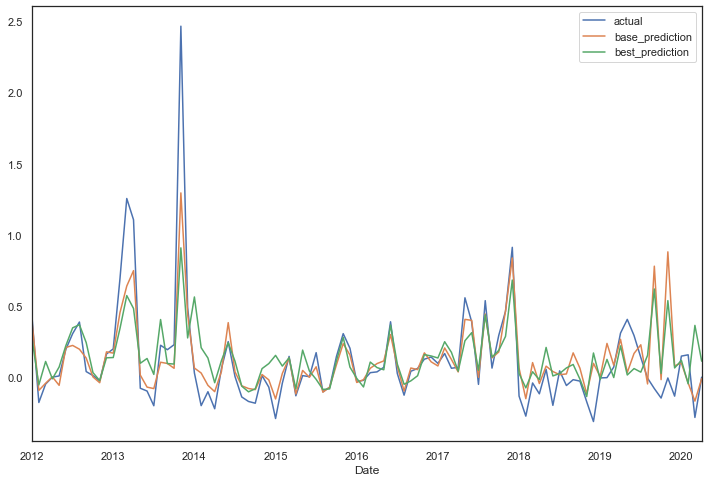

In [250]:
y.plot(figsize = (12,8))
print("The rmse is for the best model:", metrics.mean_squared_error(y['actual'], best_predictions))
print("The mae is for the best model:", metrics.mean_absolute_error(y['actual'], best_predictions))
print("The rmse is for the base model:", metrics.mean_squared_error(y['actual'], base_predictions))
print("The mae is for the base model:", metrics.mean_absolute_error(y['actual'], base_predictions))

Unfortunately, the tunning actually gave us a worse model as it seems.